In [1]:
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io as sio
from scipy import stats
import glob
import os
import shutil

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [2]:
from behavioral_analysis_functions import perf_per_dir, beh_same_opp_quad

# Setup

In [87]:
monkey = 'Neville'

In [88]:
brain_areas = ['LIP', 'MST', 'MT']

# path for merged  data files
datapath = 'E:\\two_boundary\\data\\' + monkey + '\\'

# stimulus directions
dirs = [247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5]
ord_ind = np.argsort(dirs)
ord_dirs = [dirs[i] for i in ord_ind]

# Plotting colors
color_cat1 = '#3891A6'
color_cat2 = '#DB6C79'

save_filetype = ['png', 'pdf']


# Analysis

In [89]:
acc_mean_per_area = [[] for i in range(len(brain_areas))]
acc_std_per_area = [[] for i in range(len(brain_areas))]
acc_whisker_per_area = [[] for i in range(len(brain_areas))]


acc_all_areas_bar = []
acc_all_areas_whisker = []


for i, area in enumerate(brain_areas):
    
    currpath = datapath + area
    os.chdir(currpath)

    filelist = [f for f in glob.glob("*_merged_w_ratings.mat")]

    # For bar plot
    [acc, acc_mean, acc_std] = perf_per_dir(filelist)
    
    acc_mean_per_area[i] = acc_mean
    acc_std_per_area[i] = acc_std
    acc_all_areas_bar.append(acc)

    
    # For whisker plot
    acc = beh_same_opp_quad(filelist)
    acc = [i*100 for i in acc]
    
    acc_whisker_per_area[i] = np.squeeze(acc)
    
    if len(acc_all_areas_whisker) == 0:
        acc_all_areas_whisker = np.squeeze(acc)
    else:
        acc_all_areas_whisker = np.concatenate([acc_all_areas_whisker, np.squeeze(acc)], 1)
    
acc_all_areas_bar = np.vstack(acc_all_areas_bar)
acc_mean = [np.mean(acc_all_areas_bar, 0)[i] for i in ord_ind]
acc_std = [np.std(acc_all_areas_bar, 0)[i] for i in ord_ind]


# Plotting

## Performance per area


### Bar plot

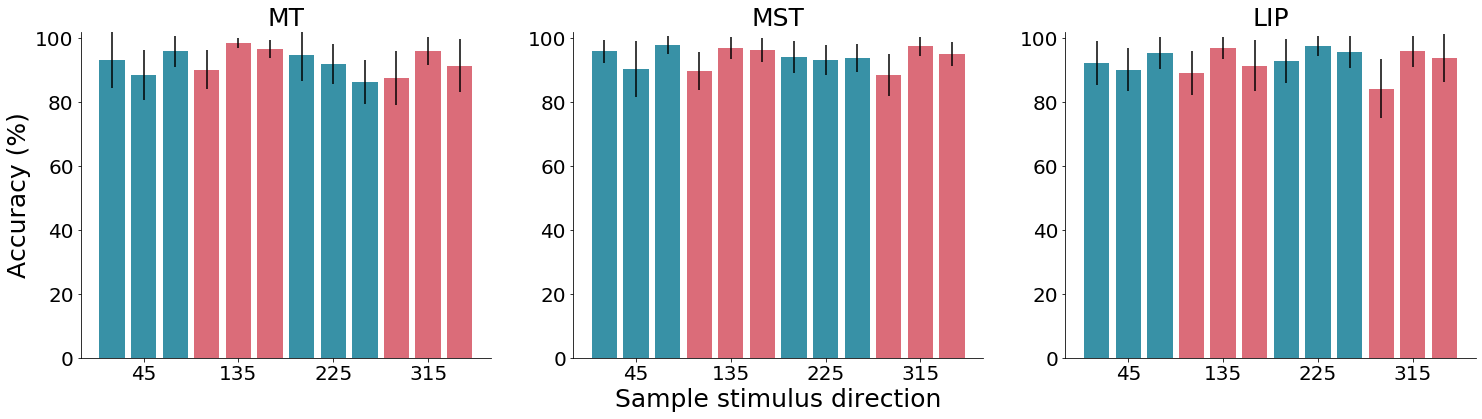

In [90]:
xtick_dirs = [ord_dirs[i] for i in np.arange(1, 11, 3)]

fig, ax =  plt.subplots(1, 3, figsize=(25, 6))

colors = [color_cat1, color_cat1, color_cat1, color_cat2, color_cat2, color_cat2, color_cat1, color_cat1, color_cat1, color_cat2, color_cat2, color_cat2]

for i in range(3):
    ax[2-i].bar(range(1, 13), acc_mean_per_area[i],  yerr = acc_std_per_area[i], align='center', color = colors)
    ax[2-i].set_title(brain_areas[i], fontsize = 25)
    #x[2-i].set_xlim(-.2, .2)
    ax[2-i].set_ylim(0, 102)
    ax[2-i].set_xticks(np.arange(2, 12, 3))
    ax[2-i].set(xticklabels = xtick_dirs)

ax[1].set_xlabel('Sample stimulus direction', fontsize = 25)
ax[0].set_ylabel('Accuracy (%)', fontsize = 25)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(labelsize=20)
    #ax[i].set_ylim(0, 0.0016)
    #ax[i].set_xticks(np.arange(-0.2, 0.21, 0.1))

plt.show()

for i in save_filetype:
    fname = 'E:\\two_boundary\\figures\\behavior\\beh_' + monkey + '_per_area_bar.' + i
    fig.savefig(fname, bbox_inches='tight')


### Whisker plot

In [91]:
ttest_pvals = np.zeros(3)

for i in range(3):
    ttest_pvals[i] = stats.ttest_ind(acc_whisker_per_area[i][0], acc_whisker_per_area[i][1])[1]

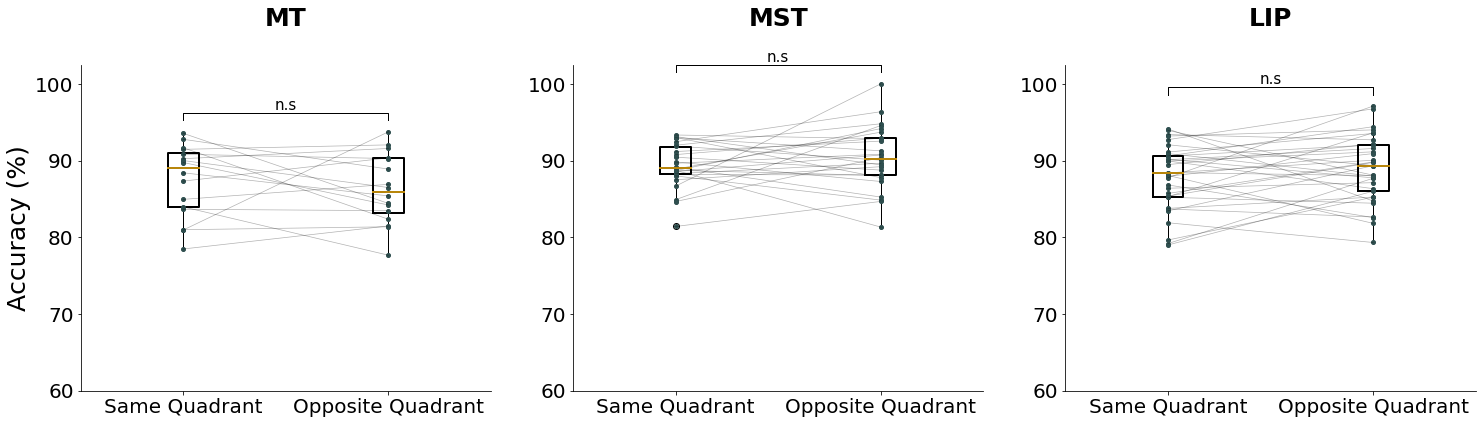

In [92]:
x_labels = ['Same Quadrant','Opposite Quadrant']
boxprops = dict(linewidth = 2, color = 'k')
medianprops = dict(linewidth=2, color='darkgoldenrod')

fig, ax =  plt.subplots(1, 3, figsize=(25, 6))
x1, x2 = 1, 2

for i in range(3):
    ax[2-i].boxplot([[ii for ii in acc_whisker_per_area[i][0]], [ii for ii in acc_whisker_per_area[i][1]]], labels = x_labels, showcaps = False, boxprops=boxprops, medianprops=medianprops)
    ax[2-i].set_title(brain_areas[i], fontsize = 25, y = 1.1, fontweight = 'bold')
    #x[2-i].set_xlim(-.2, .2)
    ax[2-i].set_ylim(60, 102.5)
    
    if ttest_pvals[i] > 0.05:
        sigtext = 'n.s'
    elif ttest_pvals[i] <= 0.05 and pvals_dir[i] > 0.01:
        sigtext = '*'                 
    elif ttest_pvals[i] <= 0.01 and pvals_dir[i] > 0.005:
        sigtext = '**'      
    elif ttest_pvals[i] <= 0.005 and pvals_dir[i] > 0.005:
        sigtext = '***'  
    else:
        sigtext = '****'      
                          
    y, h, col = np.max(acc_whisker_per_area[i]) + 1.5, 1, 'k'
    ax[2-i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    ax[2-i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 15)
    
    for ii in range(np.size(acc_whisker_per_area[i], 1)):
        ax[2-i].plot (1, acc_whisker_per_area[i][0][ii],  'o', color = 'darkslategrey', markersize = 4)
        ax[2-i].plot (2, acc_whisker_per_area[i][1][ii], 'o', color = 'darkslategrey', markersize = 4)
        ax[2-i].plot([1,2], [acc_whisker_per_area[i][0][ii],acc_whisker_per_area[i][1][ii]],  lw = 0.7, color = 'black', alpha = 0.3)

#ax[1].set_xlabel('Sample and test stimulus', fontsize = 25)
ax[0].set_ylabel('Accuracy (%)', fontsize = 25)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(labelsize=20)
    #ax[i].set_ylim(0, 0.0016)
    #ax[i].set_xticks(np.arange(-0.2, 0.21, 0.1))

plt.show()

for i in save_filetype:
    fname = 'E:\\two_boundary\\figures\\behavior\\beh_' + monkey + '_per_area_whisker.' + i
    fig.savefig(fname, bbox_inches='tight')


## Performance across areas (combined)


### Bar plot

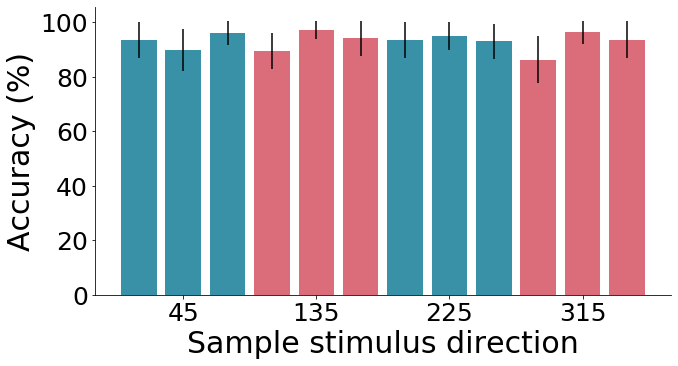

In [93]:
## PLOTTING
xtick_dirs = [ord_dirs[i] for i in np.arange(1, 11, 3)]
colors = [color_cat1, color_cat1, color_cat1, color_cat2, color_cat2, color_cat2, color_cat1, color_cat1, color_cat1, color_cat2, color_cat2, color_cat2]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1,1,1,1])

ax.bar(range(1, 13), acc_mean, yerr = acc_std, align='center', color = colors)

ax.set_xlabel('Sample stimulus direction', fontsize = 30)
ax.set_ylabel('Accuracy (%)', fontsize = 30)

plt.yticks(fontsize=25, rotation=0)
plt.xticks(fontsize=25, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(np.arange(2, 12, 3))
ax.set(xticklabels = xtick_dirs)


plt.show()

for i in save_filetype:
    fname = 'E:\\two_boundary\\figures\\behavior\\beh_' + monkey + '_all_areas_bar.' + i
    fig.savefig(fname, bbox_inches='tight')


### Whiker plot

In [94]:
pval = stats.ttest_ind(acc_all_areas_whisker[0], acc_all_areas_whisker[1])[1]

In [95]:
boxprops = dict(linewidth = 2, color = 'k')
medianprops = dict(linewidth=2, color='darkgoldenrod')

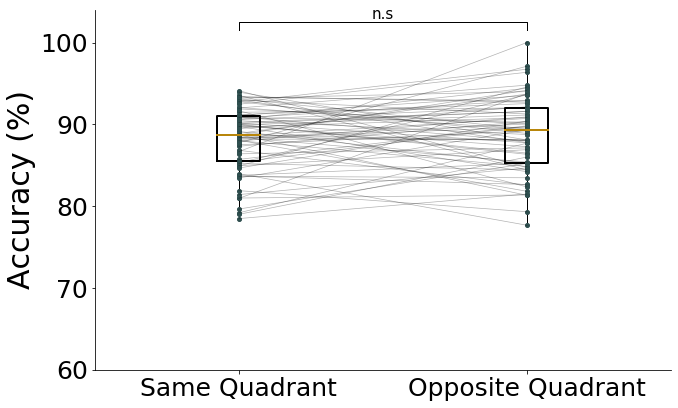

In [96]:
x_labels = ['Same Quadrant','Opposite Quadrant']

## PLOTTING

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([1,1,1,1])

plt.boxplot([[i for i in acc_all_areas_whisker[0]], [i for i in acc_all_areas_whisker[1]]], labels = x_labels, showcaps = False, boxprops=boxprops, medianprops=medianprops)

plt.ylim(60, 104)
#plt.title('Opposite vs Within Quadrant Accuracy {}'.format(area))

for i in range(np.size(acc_all_areas_whisker, 1)):
    plt.plot (1, acc_all_areas_whisker[0][i],  'o', color = 'darkslategrey', markersize = 4)
    plt.plot (2, acc_all_areas_whisker[1][i], 'o', color = 'darkslategrey', markersize = 4)
    plt.plot([1,2], [acc_all_areas_whisker[0][i],acc_all_areas_whisker[1][i]],  lw = 0.7, color = 'black', alpha = 0.3)
    
if pval > 0.05:
    sigtext = 'n.s'
elif pval <= 0.05 and pvals_dir[i] > 0.01:
    sigtext = '*'                 
elif pval <= 0.01 and pvals_dir[i] > 0.005:
    sigtext = '**'      
elif pval <= 0.005 and pvals_dir[i] > 0.005:
    sigtext = '***'  
else:
    sigtext = '****'      

y, h, col = np.max(acc_all_areas_whisker) + 1.5, 1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
ax.text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 15)
    
ax.set_ylabel('Accuracy (%)', fontsize = 30)

plt.yticks(fontsize=25, rotation=0)
plt.xticks(fontsize=25, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks(np.arange(60, 101, 10))

plt.show()
for i in save_filetype:
    fname = 'E:\\two_boundary\\figures\\behavior\\beh_' + monkey + '_all_areas_whisker.' + i
    fig.savefig(fname, bbox_inches='tight')
